# 0.Setting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

os.chdir('/content/gdrive/MyDrive/2021 여름방학/2021 빅콘테스트/2021 빅콘테스트_홍수ZERO_데이터/01_제공데이터')

# 1. Data Preprocessing

In [ ]:
# 컬럼명 재정의
pd.set_option('display.max_columns',None) # ...으로 요약 안 되게
data  = pd.read_csv('홍수zero_rawdata.csv')
# 강우: rf / 수위: wl
data.columns = ('num','year','month','day','time','inflow(y)','average_1','rfA_1','rfB_1','rfC_1','rfD_1','wlE_1','wlD_1','average_2','rfA_2','rfB_2','rfC_2','rfD_2','wlE_2','wlD_2','average_3','rfA_3','rfB_3','rfC_3','rfD_3','wlE_3','wlD_3','average_4','rfA_4','rfB_4','rfC_4','rfD_4','wlE_4','wlD_4','average_5','rfA_5','rfB_5','rfC_5','rfD_5','wlE_5','wlD_5','average_6','rfA_6','rfB_6','rfC_6','rfD_6','wlE_6','wlD_6')
data = data.iloc[1:,:].reset_index(drop=True)
#컬럼 순서 바꾸기(종속변수를 맨 뒤로)
data = data[['num','year','month','day','time','average_1','rfA_1','rfB_1','rfC_1','rfD_1','wlE_1','wlD_1','average_2','rfA_2','rfB_2','rfC_2','rfD_2','wlE_2','wlD_2','average_3','rfA_3','rfB_3','rfC_3','rfD_3','wlE_3','wlD_3','average_4','rfA_4','rfB_4','rfC_4','rfD_4','wlE_4','wlD_4','average_5','rfA_5','rfB_5','rfC_5','rfD_5','wlE_5','wlD_5','average_6','rfA_6','rfB_6','rfC_6','rfD_6','wlE_6','wlD_6','inflow(y)']]
df1 = pd.DataFrame(data)
# date 변수 생성
y = ['0'+str(x)[:-2] if len(str(x)[:-2])==1 else str(x)[:-2] for x in df1['year']]
m = ['0'+str(x)[:-2] if len(str(x)[:-2])==1 else str(x)[:-2] for x in df1['month']]
d = ['0'+str(x)[:-2] if len(str(x)[:-2])==1 else str(x)[:-2] for x in df1['day']]
t = [x-1 for x in df1['time']]
t = ['0'+str(x)[:-2]+':00:00' if len(str(x)[:-2])==1 else str(x)[:-2]+':00:00' for x in df1['time']]
date = pd.DataFrame()
date['date'] = [np.nan for i in range(len(t))]
date['date'] = pd.DataFrame([y[i]+'-'+m[i]+'-'+d[i]+'-'+t[i] for i in range(len(y))])
df2 = pd.concat([date['date'],df1.iloc[:,5:]], axis=1)
df2.iloc[:,1:] = df2.iloc[:,1:].apply(pd.to_numeric, errors='coerce') #numeric으로
df2['date'] = df2['date'].apply(pd.to_datetime, errors='coerce') #datetime으로
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d-%H:%M:%S')
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day

df2 = df2[['date','year','month','day','average_1','rfA_1','rfB_1','rfC_1','rfD_1','wlE_1','wlD_1','average_2','rfA_2','rfB_2','rfC_2','rfD_2','wlE_2','wlD_2','average_3','rfA_3','rfB_3','rfC_3','rfD_3','wlE_3','wlD_3','average_4','rfA_4','rfB_4','rfC_4','rfD_4','wlE_4','wlD_4','average_5','rfA_5','rfB_5','rfC_5','rfD_5','wlE_5','wlD_5','average_6','rfA_6','rfB_6','rfC_6','rfD_6','wlE_6','wlD_6','inflow(y)']]

# 마무리
df = df2.copy() #전체 데이터
train = df2.iloc[0:2891,:].copy().reset_index(drop=True) #트레인셋
test = df2.iloc[2891:,:].copy().reset_index(drop=True) #테스트셋

In [ ]:
df

,date,year,month,day,average_1,rfA_1,rfB_1,rfC_1,rfD_1,wlE_1,wlD_1,average_2,rfA_2,rfB_2,rfC_2,rfD_2,wlE_2,wlD_2,average_3,rfA_3,rfB_3,rfC_3,rfD_3,wlE_3,wlD_3,average_4,rfA_4,rfB_4,rfC_4,rfD_4,wlE_4,wlD_4,average_5,rfA_5,rfB_5,rfC_5,rfD_5,wlE_5,wlD_5,average_6,rfA_6,rfB_6,rfC_6,rfD_6,wlE_6,wlD_6,inflow(y)
0,2006-07-10 08:00:00,2006.0,7.0,10.0,6.4,7,7,7,8,2.5,122.6,6.3,7,7,7,8,2.5,122.5,6.3,7,7,7,8,2.5,122.6,6.4,7,7,8,8,2.5,122.7,6.4,7,7,8,8,2.5,122.7,6.4,7,7,8,8,2.5,122.6,189.1
1,2006-07-10 09:00:00,2006.0,7.0,10.0,6.3,7,8,7,8,2.5,122.6,6.4,7,8,7,8,2.5,122.6,6.4,7,8,7,8,2.5,122.6,7.3,7,8,10,10,2.5,122.7,7.3,7,8,10,10,2.5,122.6,7.3,7,8,10,10,2.5,122.6,217.0
2,2006-07-10 10:00:00,2006.0,7.0,10.0,6.4,7,9,7,8,2.5,122.6,7.3,7,9,7,8,2.5,122.6,7.3,7,9,8,8,2.5,122.6,8.2,7,9,10,11,2.5,122.7,8.2,7,9,10,11,2.5,122.6,8.2,7,9,10,11,2.5,122.6,251.4
3,2006-07-10 11:00:00,2006.0,7.0,10.0,7.3,7,10,7,8,2.5,122.6,8.2,7,10,8,8,2.5,122.6,8.2,7,10,10,10,2.5,122.6,11.3,9,10,15,14,2.5,122.7,11.3,9,10,15,14,2.5,122.6,11.3,9,10,15,14,2.5,122.6,302.8
4,2006-07-10 12:00:00,2006.0,7.0,10.0,8.2,7,12,8,10,2.5,122.6,11.3,9,12,10,10,2.5,122.6,11.3,9,12,10,11,2.5,122.6,14.4,12,12,18,16,2.5,122.6,14.4,12,12,18,16,2.5,122.6,14.4,12,12,18,16,2.5,122.6,384.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,2018-07-07 17:00:00,2018.0,7.0,7.0,2.4,1,0,0,0,3.2,130.0,2.4,1,0,0,0,3.2,130.0,2.4,1,0,0,0,3.2,130.0,2.4,1,0,1,0,3.2,129.9,2.4,1,0,1,0,3.2,129.9,2.2,1,0,0,0,3.2,130.0,NaN
3047,2018-07-07 18:00:00,2018.0,7.0,7.0,2.4,1,0,0,0,3.2,130.0,2.4,1,0,0,0,3.2,130.0,2.4,1,0,0,0,3.2,130.0,2.4,1,0,1,0,3.2,129.9,2.4,1,0,1,0,3.2,129.9,2.1,1,0,0,0,3.2,130.0,NaN
3048,2018-07-07 19:00:00,2018.0,7.0,7.0,2.4,1,0,0,0,3.1,130.0,2.4,1,0,0,0,3.1,130.0,2.4,1,0,0,0,3.1,130.0,2.4,1,0,1,0,3.1,129.9,2.4,1,0,1,0,3.1,129.9,2.0,1,0,0,0,3.1,130.0,NaN
3049,2018-07-07 20:00:00,2018.0,7.0,7.0,2.4,1,0,0,0,3.1,130.0,2.4,1,0,0,0,3.1,130.0,2.4,1,0,0,0,3.1,130.0,2.4,1,0,1,0,3.1,129.9,2.3,1,0,1,0,3.1,130.0,1.9,1,0,0,0,3.1,130.0,NaN


# 2. Modeling

In [ ]:
train_X = train.drop(['inflow(y)'], axis=1)
train_y = train['inflow(y)']
test_X = test.drop(['inflow(y)'], axis=1)
test_y = test['inflow(y)']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_X,
                                                        train_y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state = 500)

In [ ]:
rbst_scaler=RobustScaler()
X_rbst=rbst_scaler.fit_transform(new_train)
test_rbst=rbst_scaler.transform(new_test)

예제2

https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/ 

Text(0, 0.5, 'inflow')

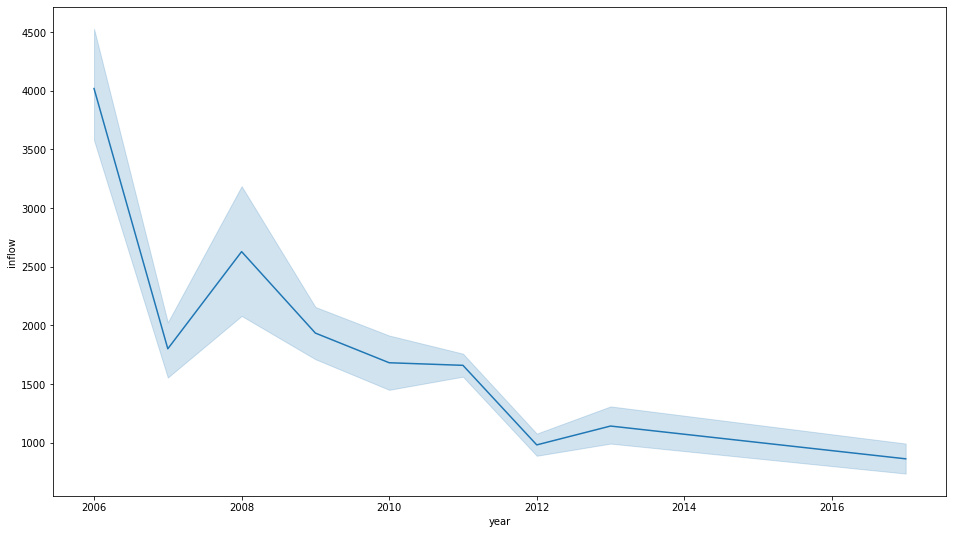

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=train['inflow(y)'], x=(train['year']))
plt.xlabel('year')
plt.ylabel('inflow')

Text(0, 0.5, 'inflow')

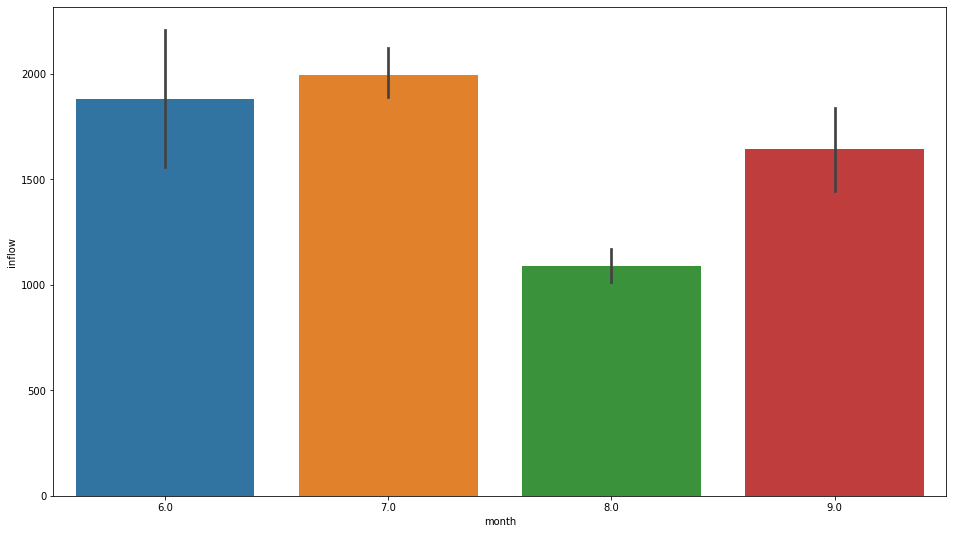

In [ ]:
plt.figure(figsize=(16, 9))
sns.barplot(y=train['inflow(y)'], x=(train['month']))
plt.xlabel('month')
plt.ylabel('inflow')

Text(0, 0.5, 'inflow')

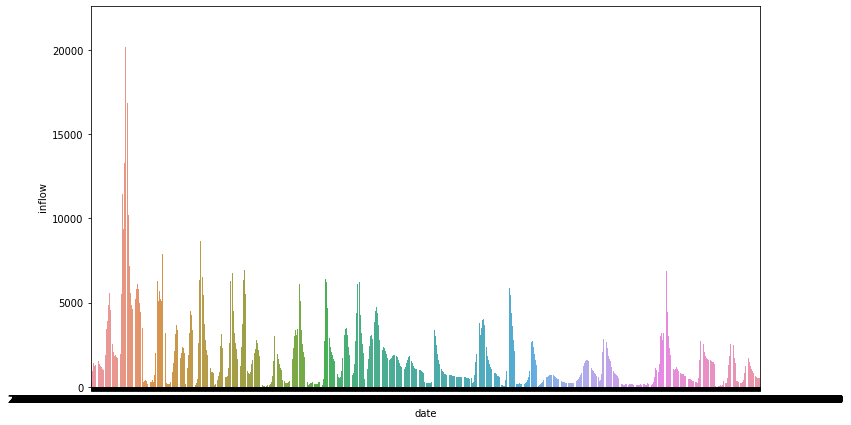

In [ ]:
plt.figure(figsize=(12, 7))
sns.barplot(y=train['inflow(y)'], x=(train['date']))
plt.xlabel('date')
plt.ylabel('inflow')

Text(0, 0.5, 'inflow')

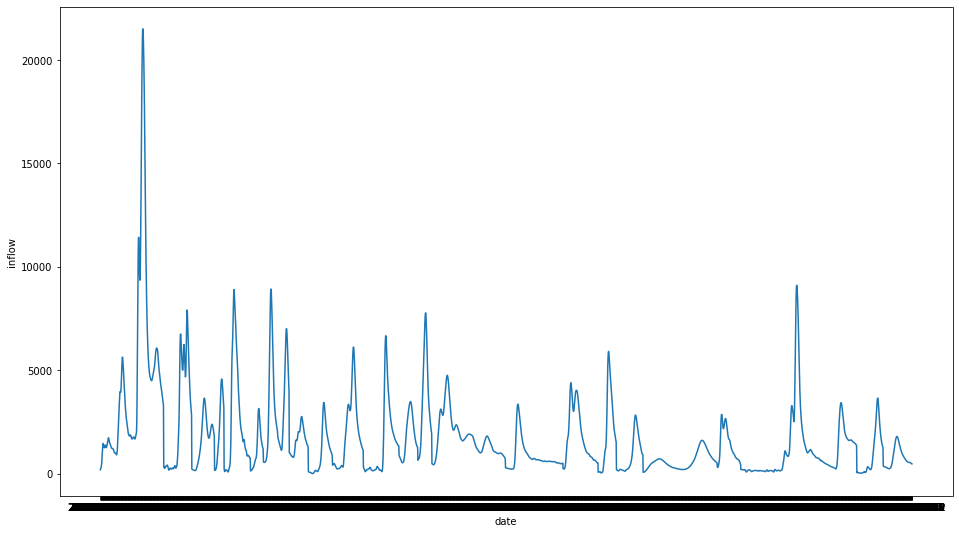

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df2['inflow(y)'], x=(df2['date']))
plt.xlabel('date')
plt.ylabel('inflow')

In [ ]:
# 데이터 정규화
df2.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['average_1','rfA_1','rfB_1','rfC_1','rfD_1','wlE_1','wlD_1','average_2','rfA_2','rfB_2','rfC_2','rfD_2','wlE_2','wlD_2','average_3','rfA_3','rfB_3','rfC_3','rfD_3','wlE_3','wlD_3','average_4','rfA_4','rfB_4','rfC_4','rfD_4','wlE_4','wlD_4','average_5','rfA_5','rfB_5','rfC_5','rfD_5','wlE_5','wlD_5','average_6','rfA_6','rfB_6','rfC_6','rfD_6','wlE_6','wlD_6','inflow(y)']
df_scaled = scaler.fit_transform(train[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,average_1,rfA_1,rfB_1,rfC_1,rfD_1,wlE_1,wlD_1,average_2,rfA_2,rfB_2,rfC_2,rfD_2,wlE_2,wlD_2,average_3,rfA_3,rfB_3,rfC_3,rfD_3,wlE_3,wlD_3,average_4,rfA_4,rfB_4,rfC_4,rfD_4,wlE_4,wlD_4,average_5,rfA_5,rfB_5,rfC_5,rfD_5,wlE_5,wlD_5,average_6,rfA_6,rfB_6,rfC_6,rfD_6,wlE_6,wlD_6,inflow(y)
0,0.019488,0.021277,0.019074,0.027668,0.030534,0.089744,0.154762,0.019184,0.020772,0.019074,0.027888,0.030534,0.089744,0.150198,0.019184,0.020772,0.019608,0.027888,0.030534,0.089744,0.154150,0.019488,0.020290,0.019608,0.028986,0.030534,0.089744,0.159363,0.019620,0.020290,0.019608,0.028986,0.030534,0.089744,0.158730,0.020101,0.020290,0.019499,0.032389,0.030651,0.089744,0.154762,0.008632
1,0.019184,0.021277,0.021798,0.027668,0.030534,0.089744,0.154762,0.019488,0.020772,0.021798,0.027888,0.030534,0.089744,0.154150,0.019488,0.020772,0.022409,0.027888,0.030534,0.089744,0.154150,0.022229,0.020290,0.022409,0.036232,0.038168,0.089744,0.159363,0.022379,0.020290,0.022409,0.036232,0.038168,0.089744,0.154762,0.022927,0.020290,0.022284,0.040486,0.038314,0.089744,0.154762,0.009930
2,0.019488,0.021277,0.024523,0.027668,0.030534,0.089744,0.154762,0.022229,0.020772,0.024523,0.027888,0.030534,0.089744,0.154150,0.022229,0.020772,0.025210,0.031873,0.030534,0.089744,0.154150,0.024970,0.020290,0.025210,0.036232,0.041985,0.089744,0.159363,0.025138,0.020290,0.025210,0.036232,0.041985,0.089744,0.154762,0.025754,0.020290,0.025070,0.040486,0.042146,0.089744,0.154762,0.011530
3,0.022229,0.021277,0.027248,0.027668,0.030534,0.089744,0.154762,0.024970,0.020772,0.027248,0.031873,0.030534,0.089744,0.154150,0.024970,0.020772,0.028011,0.039841,0.038168,0.089744,0.154150,0.034409,0.026087,0.028011,0.054348,0.053435,0.089744,0.159363,0.034641,0.026087,0.028011,0.054348,0.053435,0.089744,0.154762,0.035490,0.026087,0.027855,0.060729,0.053640,0.089744,0.154762,0.013920
4,0.024970,0.021277,0.032698,0.031621,0.038168,0.089744,0.154762,0.034409,0.026706,0.032698,0.039841,0.038168,0.089744,0.154150,0.034409,0.026706,0.033613,0.039841,0.041985,0.089744,0.154150,0.043849,0.034783,0.033613,0.065217,0.061069,0.089744,0.155378,0.044145,0.034783,0.033613,0.065217,0.061069,0.089744,0.154762,0.045226,0.034783,0.033426,0.072874,0.061303,0.089744,0.154762,0.017734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,0.069428,0.018237,0.000000,0.003953,0.003817,0.121795,0.734127,0.025274,0.017804,0.000000,0.003984,0.003817,0.121795,0.731225,0.025274,0.017804,0.000000,0.003984,0.003817,0.121795,0.731225,0.012485,0.017391,0.000000,0.003623,0.003817,0.121795,0.733068,0.010116,0.017391,0.000000,0.003623,0.003817,0.121795,0.730159,0.005339,0.017391,0.000000,0.004049,0.003831,0.121795,0.730159,0.023715
2887,0.025274,0.006079,0.000000,0.003953,0.003817,0.121795,0.734127,0.012485,0.005935,0.000000,0.003984,0.003817,0.121795,0.731225,0.012485,0.005935,0.000000,0.003984,0.003817,0.121795,0.731225,0.010353,0.005797,0.000000,0.003623,0.003817,0.121795,0.733068,0.008584,0.005797,0.000000,0.003623,0.003817,0.121795,0.730159,0.005339,0.005797,0.000000,0.004049,0.003831,0.121795,0.730159,0.023222
2888,0.012485,0.003040,0.000000,0.003953,0.003817,0.121795,0.734127,0.010353,0.002967,0.000000,0.003984,0.003817,0.121795,0.731225,0.010353,0.002967,0.000000,0.003984,0.003817,0.121795,0.731225,0.010049,0.002899,0.000000,0.003623,0.003817,0.121795,0.733068,0.006438,0.002899,0.000000,0.003623,0.003817,0.121795,0.730159,0.005339,0.002899,0.000000,0.004049,0.003831,0.121795,0.734127,0.022720
2889,0.010353,0.003040,0.000000,0.003953,0.003817,0.121795,0.734127,0.010049,0.002967,0.000000,0.003984,0.003817,0.121795,0.731225,0.010049,0.002967,0.000000,0.003984,0.003817,0.121795,0.731225,0.008526,0.002899,0.000000,0.003623,0.003817,0.121795,0.733068,0.005825,0.002899,0.000000,0.003623,0.003817,0.121795,0.730159,0.005339,0.002899,0.000000,0.004049,0.003831,0.121795,0.734127,0.022213


In [ ]:
TEST_SIZE = 200 #(테스트)예측예측해볼 데이터 크기
WINDOW_SIZE = 72 #사흘

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [ ]:
def make_dataset(data, label, window_size=48):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
feature_cols = ['average_1','rfA_1','rfB_1','rfC_1','rfD_1','wlE_1','wlD_1','average_2','rfA_2','rfB_2','rfC_2','rfD_2','wlE_2','wlD_2','average_3','rfA_3','rfB_3','rfC_3','rfD_3','wlE_3','wlD_3','average_4','rfA_4','rfB_4','rfC_4','rfD_4','wlE_4','wlD_4','average_5','rfA_5','rfB_5','rfC_5','rfD_5','wlE_5','wlD_5','average_6','rfA_6','rfB_6','rfC_6','rfD_6','wlE_6','wlD_6']
label_cols = ['inflow(y)']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 72) #하루

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((2095, 72, 42), (524, 72, 42))

In [ ]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 42), (200, 1))

In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 42), (180, 1))

In [ ]:
## 모형 학습 ##
model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = '/content/gdrive/MyDrive/2021 여름방학/2021 빅콘테스트/2021 빅콘테스트_홍수ZERO_데이터/01_제공데이터' #'model'저장경로
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid),
                                    callbacks=[early_stop, checkpoint]                   
                                    ) #callbacks=[early_stop, checkpoint]

Epoch 1/200
131/131 [==============================] - 6s 30ms/step - loss: 4.2624e-04 - val_loss: 4.3156e-04

Epoch 00001: val_loss improved from inf to 0.00043, saving model to /content/gdrive/MyDrive/2021 여름방학/2021 빅콘테스트/2021 빅콘테스트_홍수ZERO_데이터/01_제공데이터/tmp_checkpoint.h5
Epoch 2/200
131/131 [==============================] - 4s 29ms/step - loss: 4.6022e-04 - val_loss: 4.6154e-04

Epoch 00002: val_loss did not improve from 0.00043
Epoch 3/200
131/131 [==============================] - 3s 26ms/step - loss: 4.8605e-04 - val_loss: 4.3495e-04

Epoch 00003: val_loss did not improve from 0.00043
Epoch 4/200
131/131 [==============================] - 4s 28ms/step - loss: 3.7804e-04 - val_loss: 4.1608e-04

Epoch 00004: val_loss improved from 0.00043 to 0.00042, saving model to /content/gdrive/MyDrive/2021 여름방학/2021 빅콘테스트/2021 빅콘테스트_홍수ZERO_데이터/01_제공데이터/tmp_checkpoint.h5
Epoch 5/200
131/131 [==============================] - 4s 28ms/ste

In [ ]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(180, 1)

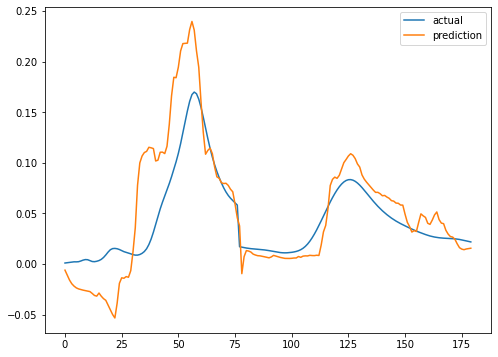

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [ ]:
pred

array([[-0.01133812],
       [-0.01527965],
       [-0.01974614],
       [-0.02351092],
       [-0.0260279 ],
       [-0.02789144],
       [-0.02910448],
       [-0.02976401],
       [-0.03043043],
       [-0.03106048],
       [-0.031176  ],
       [-0.03106828],
       [-0.03231367],
       [-0.03378262],
       [-0.03379939],
       [-0.03045276],
       [-0.03410471],
       [-0.03776841],
       [-0.04096314],
       [-0.04711643],
       [-0.05327638],
       [-0.05910625],
       [-0.06353757],
       [-0.04922424],
       [-0.02965229],
       [-0.02427857],
       [-0.02615955],
       [-0.02682006],
       [-0.0292812 ],
       [-0.02400647],
       [-0.00738104],
       [ 0.01441882],
       [ 0.05322061],
       [ 0.07492355],
       [ 0.08286885],
       [ 0.08756167],
       [ 0.09214161],
       [ 0.10290719],
       [ 0.10542552],
       [ 0.10695917],
       [ 0.09706663],
       [ 0.09709381],
       [ 0.10291382],
       [ 0.10154999],
       [ 0.10136454],
       [ 0